# Watermark Detection

Types of watermarks in images:
1. **Text Watermarks**: These are the most common type. They usually contain the name of the photographer, artist, or company that owns the image. Text watermarks can vary in size, color, and placement to either be discreet or more noticeable.

2. **Logo Watermarks**: Instead of text, some prefer using a logo or symbol that represents their brand or identity. These are particularly common for companies or professional photographers.

3. **Tile Watermarks**: These cover the entire image with a repeated pattern of text or logo. They are designed to be very difficult to remove without damaging the underlying image.

Properties of watermarks:

1. **Color**: The color of the watermark can be chosen to contrast with the image, making it more visible, or to blend in, making it less obtrusive. Common choices are black, white, or shades of gray, but any color can be used.

2. **Opacity**: The transparency level of the watermark is crucial. A more transparent (or lower opacity) watermark is less noticeable, while a less transparent (or higher opacity) one is more prominent.

3. **Size**: Watermarks can range from small and discreet to large and covering a significant part of the image. The size often depends on how noticeable the owner wants the watermark to be.

4. **Font**: The choice of font can greatly affect the appearance of text watermarks. Fonts can range from simple and professional to artistic and decorative.

5. **Position**: The placement of the watermark on the image is important. Common positions include corners, the center, or along the edges. Some choose to place the watermark in a spot that is hard to remove without damaging the image.

6. **Rotation and Alignment**: Watermarks can be aligned horizontally, vertically, or even diagonally. The rotation and alignment can affect how the watermark interacts with the image.

7. **Pattern (for tiled watermarks)**: If a tiled watermark is used, the pattern and frequency of the tile can be adjusted. This type of watermark repeats across the image.

Characteristics of datasets:
1. Single and multi watermarked images
2. Overlapping and non-overlapping watermarks
3. Non aligned bounding boxes (4 coordinates)
4. 256x256 images
5. 100k base images in total from image-net (all classes)
6. Logos from this dataset: https://hangsu0730.github.io/qmul-openlogo/

In [1003]:
# read all images in data/

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import matplotlib.font_manager as fm
from PIL import ImageFont

flist = fm.findSystemFonts()
names = [fm.FontProperties(fname=fname).get_file().split("\\")[-1].lower() for fname in flist]
print(len(names))
for name in names[::]:
    try:
        font = ImageFont.truetype(name)
    except Exception as e:
        names.remove(name)
print(len(names))

# load all images
data = []
for filename in os.listdir(os.path.join("data", "pictures")):
    img = Image.open(os.path.join("data", "pictures", filename))
    data.append(img)

344
121


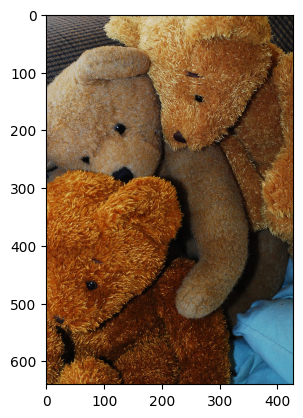

In [1004]:
from matplotlib import pyplot as plt
import numpy as np

test_img = data[4]

plt.imshow(test_img)
plt.show()

In [1005]:
# import all the libraries
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import matplotlib.pyplot as plt
import numpy as np

def add_text_watermark(img, txt, position, color, fontname, orientation, size):
    # text Watermark
    new_img = img.copy().convert('RGBA')
    txt_new_img = Image.new('RGBA', new_img.size, (255,255,255,0))
    txt_image = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt_image)
    font = ImageFont.truetype(fontname, size)
    draw.text(position, txt, fill=(0, 0, 0, 255), font=font, anchor='ms')
    txt_image = txt_image.rotate(orientation)

    draw = ImageDraw.Draw(txt_new_img)
    draw.text(position, txt, fill=color, font=font, anchor='ms')
    txt_new_img = txt_new_img.rotate(orientation)
    combined = Image.alpha_composite(new_img, txt_new_img)

    # bouding boxes
    bbox = txt_new_img.getbbox()

    return combined, txt_image, bbox

In [1006]:
import random
import string

def generate_random_string(length):
    letters = string.printable
    letters += string.whitespace.replace('\n', '').replace('\t', '')
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

generate_random_string(10)

"+Oo'q2rC}Y"

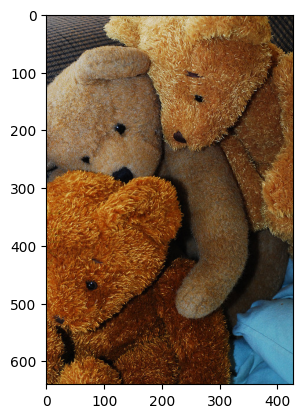

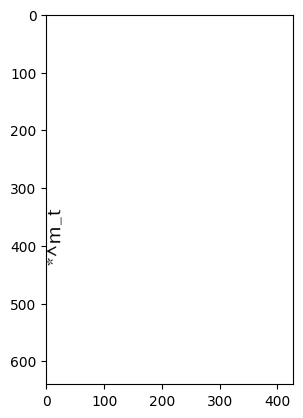

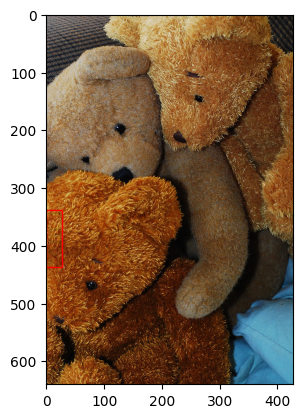

In [1007]:
def add_random_text_watermark(img):
    w, h = img.size
    txt = generate_random_string(np.random.randint(1, 25))
    position = (np.random.randint(0, w), np.random.randint(0, h))
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(15, 255))
    fontname = np.random.choice(names)
    orientation = np.random.choice([0, 90, 180, 270])
    size = np.random.randint(5, min(w, h) // 3)
    return add_text_watermark(img, txt, position, color, fontname, orientation, size)

# add text watermark
def add_random_text_watermarks(img, k):
    total_txt_image = Image.new('RGBA', img.size, (255,255,255,0))
    watermark_image = img.copy().convert('RGBA')
    
    bboxes, labels = [], []
    while k > 0:
        watermark_image, txt_image, bbox = add_random_text_watermark(watermark_image)
        total_txt_image = Image.alpha_composite(total_txt_image, txt_image)
        if bbox is None:
            continue
        bboxes.append(bbox)
        labels.append("text")
        k -= 1
    return watermark_image, total_txt_image, bboxes, labels

watermark_image, total_txt_image, bboxes, labels = add_random_text_watermarks(test_img, 1)

plt.imshow(watermark_image)
plt.show()
plt.imshow(total_txt_image)
plt.show()

# bbox
from matplotlib import patches

def plot_bbox(img, bboxes, labels):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox, label in zip(bboxes, labels):
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

plot_bbox(watermark_image, bboxes, labels)

In [1008]:
X_data_watermarked = []
y_data_watermarked = []
y_data_bbox = []
y_data_labels = []

txt_per_image = 1

for img in tqdm(data):
    watermark_image, total_txt_image, bboxes, labels = add_random_text_watermarks(img, txt_per_image)
    # adapt the bboxes to the new size
    bboxes = np.array(bboxes)
    for i in range(len(bboxes)):
        bbox = bboxes[i]
        bbox[0] = bbox[0] * 224 // img.size[0]
        bbox[1] = bbox[1] * 224 // img.size[1]
        bbox[2] = bbox[2] * 224 // img.size[0]
        bbox[3] = bbox[3] * 224 // img.size[1]
    watermark_image = watermark_image.resize((224, 224))
    total_txt_image = total_txt_image.resize((224, 224))
    # convert watermark_image to 3 channels (remove alpha channel)
    watermark_image = watermark_image.convert('RGB')

    # convert total_txt_image to grayscale
    total_txt_image = np.average(np.array(total_txt_image), axis=2)
    
    X_data_watermarked.append(np.array(watermark_image))
    y_data_watermarked.append(np.array(total_txt_image))
    y_data_bbox.append(bboxes)
    y_data_labels.append(labels)

# convert to numpy array
X_data_watermarked = np.array(X_data_watermarked)
y_data_watermarked = np.array(y_data_watermarked)

print(X_data_watermarked.shape, y_data_watermarked.shape, len(y_data_bbox), len(y_data_labels))

100%|██████████| 5000/5000 [02:23<00:00, 34.80it/s]


(5000, 224, 224, 3) (5000, 224, 224) 5000 5000


In [1009]:
# train val split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data_watermarked, y_data_bbox, test_size=0.2, random_state=42, shuffle=False)

In [1010]:
import json
import shutil

def save_data(X_data, y_data, y_data_bbox, filename, sub_folder, sub_sub_folder, zip=False):
    origin_path = os.path.join("data", "dataset", sub_folder, sub_sub_folder)

    # delete if exists
    if os.path.exists(origin_path):
        shutil.rmtree(origin_path)
    os.makedirs(origin_path)

    # save images as jpg and y bbox as json x, y, w, h
    for i in trange(len(X_data)):
        img = Image.fromarray(X_data[i])
        img.save(os.path.join("data", "dataset", sub_folder, sub_sub_folder, "images", filename + "_" + sub_sub_folder + "_" + str(i) + ".jpg"))
        with open(os.path.join("data", "dataset", sub_folder, sub_sub_folder, "labels", filename + "_" + sub_sub_folder + "_" + str(i) + ".json"), 'w') as f:
            json_list = []
            for j in range(len(y_data_bbox[i])):
                bbox = y_data_bbox[i][j]
                json_list.append({
                    "label" : y_data_labels[i][j],
                    "bbox" : [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]
                })
            json.dump(json_list, f)
    
    if zip:
        shutil.make_archive(origin_path, 'zip', origin_path)

save_data(X_train, y_train, y_data_bbox, "watermarked", "text", "train", zip=True)
save_data(X_val, y_val, y_data_bbox, "watermarked", "text", "val", zip=True)

100%|██████████| 1000/1000 [00:03<00:00, 283.30it/s]


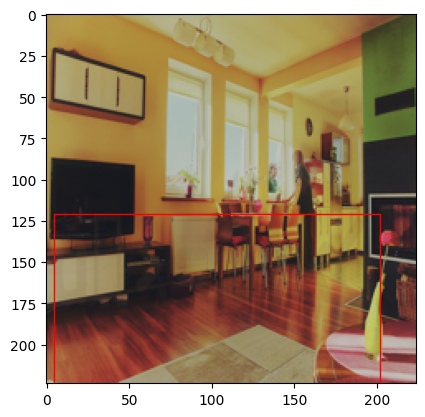

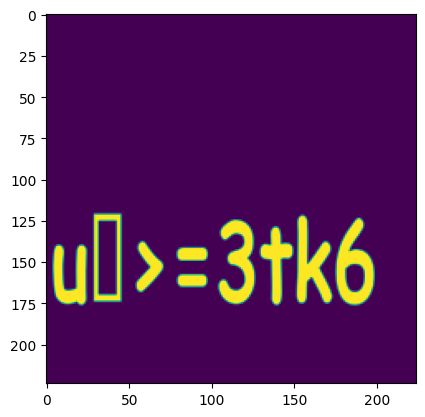

In [1011]:
import matplotlib.patches as patches

k = 0
# draw one example
fig, ax = plt.subplots(1)
ax.imshow(X_train[k])
for bbox in y_train[k]:
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

# plot the ground truth
fig, ax = plt.subplots(1)
ax.imshow(y_data_watermarked[k])
plt.show()

## Icon gen

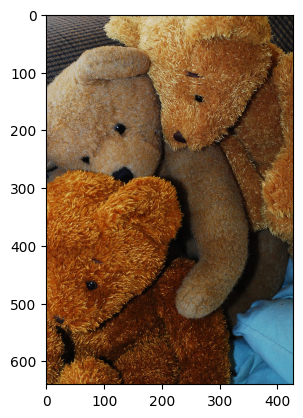

In [1023]:
from matplotlib import pyplot as plt
import numpy as np

test_img = data[4]

plt.imshow(test_img)
plt.show()

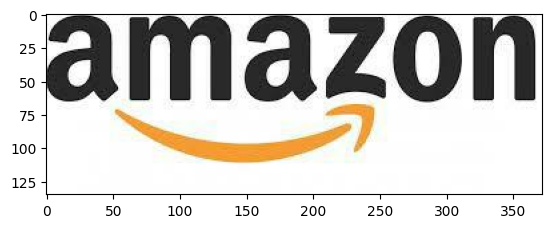

In [1024]:
# load icon images from data/logos
logos = []
for filename in os.listdir(os.path.join("data", "logos")):
    img = Image.open(os.path.join("data", "logos", filename))
    logos.append(img)

plt.imshow(logos[16])
plt.show()

100%|██████████| 352/352 [00:01<00:00, 224.95it/s]


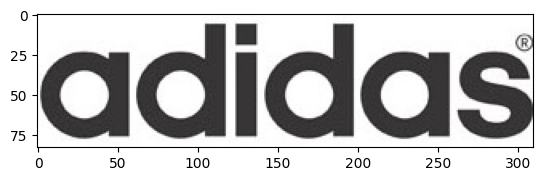

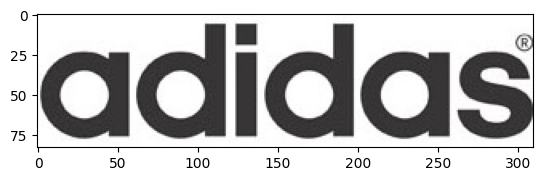

In [1025]:
import numpy as np
from rembg import remove 

# remove white background from logos
def remove_background(img):
    # img = remove(img)
    # add transparency
    img = img.convert('RGBA')
    return img

no_bg_logos = [remove_background(img) for img in tqdm(logos)]

fig, ax = plt.subplots(1)
ax.imshow(logos[5])
ax.set_facecolor((0, 0, 0))
plt.show()

fig, ax = plt.subplots(1)
ax.imshow(no_bg_logos[5])
ax.set_facecolor((0, 0, 0))
plt.show()

In [1026]:
from PIL import Image
import numpy as np

def add_logo_watermark(img, logo_img, position, orientation, size, opacity):
    # Convert the main image to RGBA
    new_img = img.copy().convert('RGBA')

    # Resize logo
    logo_resized = logo_img.convert('RGBA')
    logo_resized = logo_img.resize((int(logo_img.width * size), int(logo_img.height * size)))

    # opacity multiplier
    alpha = opacity / 255
    logo_resized = np.array(logo_resized)
    logo_resized[:, :, 3] = logo_resized[:, :, 3] * alpha
    logo_resized = Image.fromarray(logo_resized)

    # Create an image for the transformed logo
    logo_transformed = Image.new('RGBA', img.size, (0, 0, 0, 0))
    logo_resized = logo_resized.rotate(orientation, expand=1)
    logo_transformed.paste(logo_resized, position)

    bbox = logo_resized.getbbox()

    # Composite the images
    combined = Image.alpha_composite(new_img, logo_transformed)

    return combined, logo_transformed, (*position, bbox[2], bbox[3])

def add_random_logo_watermark(img):
    w, h = img.size

    logo_img = no_bg_logos[np.random.randint(0, len(no_bg_logos))]
    # Randomly scale and place the logo
    max_logo_size = np.random.uniform(0.1, 1)  # Restrict the size of the logo
    scale_factor = max_logo_size / max(logo_img.width, logo_img.height) * min(img.width, img.height)
    new_size = (int(logo_img.width * scale_factor), int(logo_img.height * scale_factor))
    
    max_x = w - new_size[0]
    max_y = h - new_size[1]
    position = (np.random.randint(0, max_x), np.random.randint(0, max_y))

    orientation = np.random.choice([0, 90, 180, 270])
    opacity = np.random.randint(15, 255)  # Ensure logo is visible
    
    return add_logo_watermark(img, logo_img, position, orientation, scale_factor, opacity)

def add_random_logo_watermarks(img, k):
    total_logo_image = Image.new('RGBA', img.size, (255, 255, 255, 0))
    watermark_image = img.copy().convert('RGBA')
    
    bboxes, labels = [], []
    for _ in range(k):
        watermark_image, logo_image, bbox = add_random_logo_watermark(watermark_image)
        total_logo_image = Image.alpha_composite(total_logo_image, logo_image)
        if bbox:
            bboxes.append(bbox)
            labels.append("logo")
    
    return watermark_image, total_logo_image, bboxes, labels

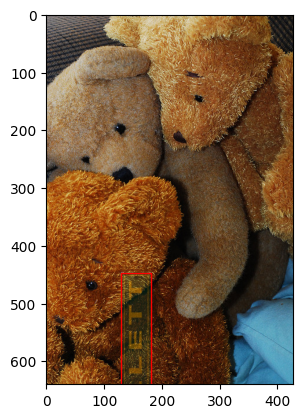

In [1027]:
# test
watermark_image, total_logo_image, bboxes, labels = add_random_logo_watermarks(test_img, 1)

fig, ax = plt.subplots(1)
ax.imshow(watermark_image)
for bbox in bboxes:
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [1028]:
# generate watermarked images with logos for all images
X_logos_watermarked = []
y_logos_watermarked = []
y_logos_bbox = []
y_logo_data_labels = []

for img in tqdm(data):
    watermark_image, total_logo_image, bboxes, labels = add_random_logo_watermarks(img, 1)
    # adapt the bboxes to the new size
    bboxes = np.array(bboxes)
    for i in range(len(bboxes)):
        bbox = bboxes[i]
        bbox[0] = bbox[0] * 224 // img.size[0]
        bbox[1] = bbox[1] * 224 // img.size[1]
        bbox[2] = bbox[2] * 224 // img.size[0]
        bbox[3] = bbox[3] * 224 // img.size[1]
    watermark_image = watermark_image.resize((224, 224))
    total_logo_image = total_logo_image.resize((224, 224))
    # convert watermark_image to 3 channels (remove alpha channel)
    watermark_image = watermark_image.convert('RGB')
    y_logo_data_labels.append(labels)

    # convert total_logo_image to grayscale
    total_logo_image = np.average(np.array(total_logo_image), axis=2)
    
    X_logos_watermarked.append(np.array(watermark_image))
    y_logos_watermarked.append(np.array(total_logo_image))
    y_logos_bbox.append(bboxes)

  0%|          | 0/10 [26:13<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
X_logos_train, X_logos_val, y_logos_train, y_logos_val = train_test_split(X_logos_watermarked, y_logos_bbox, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
save_data(X_logos_train, y_logos_train, y_logos_bbox, "watermarked", "logo", "train", zip=True)
save_data(X_logos_val, y_logos_val, y_logos_bbox, "watermarked", "logo", "val", zip=True)

100%|██████████| 1000/1000 [00:05<00:00, 178.92it/s]
